In [303]:
import numpy as np
import pandas as pd 
import json
import os
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns', 300)
pd.set_option('max_rows', 300)

In [304]:
#reading cvs file with bankrupt
bankrupts = pd.read_csv('part_1/flags.csv', sep=';')

<AxesSubplot:>

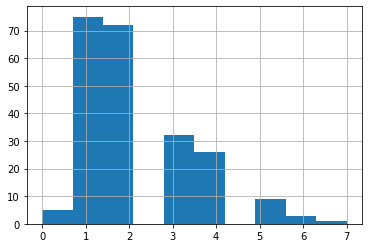

In [305]:
dataset = list()
years = [0 for i in range(15)]
for json_path in os.listdir('part_1/fin'):
    with open(os.path.join('part_1/fin', json_path), 'r') as f:
        data = json.load(f)
    dataset.append([data['id'],data['buhForms'][-1]['year']])
df = pd.DataFrame(dataset,columns = ['id','last_year'])
full = pd.merge(bankrupts, df, how='inner', on = ['id'])
full['df_year'] = full['default_date'].apply(lambda x: int(x[-4:]))
full['diference'] = full['df_year'] - full['last_year']
full['diference'].hist()

On this histogram, we see the difference between the last year we have information about and the year the company defaulted.<br>

Since there was little time, I spent most of my time selecting and generating features.<br>
To read json files and collect information, I collected unique attribute names<br>
for all files over the last year from all companies.<br>
Took startValue, endValue for each feature. So does the difference between them, and the ratio of startValue to endValue.<br>

In [306]:
indexes = []
for json_path in os.listdir('part_1/fin'):
    with open(os.path.join('part_1/fin', json_path), 'r') as f:
        data = json.load(f)
    for i in range(len(data['buhForms'][-1]['form1'])):
        indexes.append(data['buhForms'][-1]['form1'][i]['name'])
    for i in range(len(data['buhForms'][-1]['form2'])):
        indexes.append(data['buhForms'][-1]['form2'][i]['name'])
indexes = sorted(list(set(indexes)))
dictionary = {indexes[i]:4 * i for i in range(len(indexes))}

In [307]:
years = [0 for i in range(15)]
dataset = list()
for json_path in os.listdir('part_1/fin'):
    with open(os.path.join('part_1/fin', json_path), 'r') as f:
        data = json.load(f)
    list_index = [None for i in range(4 * len(dictionary))]
    for i in range(len(data['buhForms'][-1]['form1'])):
        if ('startValue'  in data['buhForms'][-1]['form1'][i]):
            list_index[dictionary.get(data['buhForms'][-1]['form1'][i]['name'])] = data['buhForms'][-1]['form1'][i]['startValue']
        if ('endValue' in data['buhForms'][-1]['form1'][i]):
            list_index[dictionary.get(data['buhForms'][-1]['form1'][i]['name']) + 1] = data['buhForms'][-1]['form1'][i]['endValue']
        if ('endValue' in data['buhForms'][-1]['form1'][i] and 'startValue'  in data['buhForms'][-1]['form1'][i]):
            list_index[dictionary.get(data['buhForms'][-1]['form1'][i]['name']) + 2] = data['buhForms'][-1]['form1'][i]['startValue'] - data['buhForms'][-1]['form1'][i]['endValue']
            if (data['buhForms'][-1]['form1'][i]['endValue'] != 0):
                list_index[dictionary.get(data['buhForms'][-1]['form1'][i]['name']) + 3] = data['buhForms'][-1]['form1'][i]['startValue'] / data['buhForms'][-1]['form1'][i]['endValue']
    for i in range(len( data['buhForms'][-1]['form2'])):
        if ('startValue' in data['buhForms'][-1]['form2'][i]):
            list_index[dictionary.get(data['buhForms'][-1]['form2'][i]['name'])] = data['buhForms'][-1]['form2'][i]['startValue']
        if ('endValue' in data['buhForms'][-1]['form2'][i]):
            list_index[dictionary.get(data['buhForms'][-1]['form2'][i]['name']) + 1] = data['buhForms'][-1]['form2'][i]['endValue']
        if ('endValue' in data['buhForms'][-1]['form2'][i] and 'startValue' in data['buhForms'][-1]['form2'][i]):
            list_index[dictionary.get(data['buhForms'][-1]['form2'][i]['name']) + 2] = data['buhForms'][-1]['form2'][i]['startValue'] - data['buhForms'][-1]['form2'][i]['endValue']
            if (data['buhForms'][-1]['form2'][i]['endValue'] != 0):
                list_index[dictionary.get(data['buhForms'][-1]['form2'][i]['name']) + 3] = data['buhForms'][-1]['form2'][i]['startValue'] / data['buhForms'][-1]['form2'][i]['endValue']
    list_index.append(data['id'])
    dataset.append(list_index)

In [308]:
#Creating names for dataframe.
column_names = [None for i in range(4 * len(dictionary))]
for json_path in os.listdir('part_1/fin'):
    with open(os.path.join('part_1/fin', json_path), 'r') as f:
        data = json.load(f)
    for i in range(len(data['buhForms'][-1]['form1'])):
        name = data['buhForms'][-1]['form1'][i]['name']
        column_names[dictionary.get(data['buhForms'][-1]['form1'][i]['name'])] = name + '_startValue' 
        column_names[dictionary.get(data['buhForms'][-1]['form1'][i]['name'])+1] = name + '_endValue'
        column_names[dictionary.get(data['buhForms'][-1]['form1'][i]['name'])+2] = name + '_differnce'
        column_names[dictionary.get(data['buhForms'][-1]['form1'][i]['name'])+3] = name + '_attitude'
    for i in range(len( data['buhForms'][-1]['form2'])):
        name = data['buhForms'][-1]['form2'][i]['name']
        column_names[dictionary.get(data['buhForms'][-1]['form2'][i]['name'])] = name + '_startValue'
        column_names[dictionary.get(data['buhForms'][-1]['form2'][i]['name'])+1] = name + '_endValue'
        column_names[dictionary.get(data['buhForms'][-1]['form2'][i]['name'])+2] = name + '_differnce'
        column_names[dictionary.get(data['buhForms'][-1]['form2'][i]['name'])+3] = name + '_attitude'
column_names.append('id')

In [309]:
#Combining csv files to create a target variable and further work on selecting and building a model.
df = pd.DataFrame(dataset,columns = column_names)
df = pd.merge(df,bankrupts,on = 'id', how = 'left')

In [310]:
df['target']= df['default_date'].fillna(0).apply(lambda x: 1 if x else x)
df['target'].value_counts()

0    3695
1     223
Name: target, dtype: int64

In [311]:
#Save pickle file and go to feature selection and desinging experiment.
df.to_pickle('dataset.pkl')